<a href="https://colab.research.google.com/github/sijiao-liu/deep_learning/blob/lab/01_materials/labs/lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Backpropagation in Multilayer Neural Networks

While we will primarily be working with high-level, abstract toolkits like Keras in this course, understanding how backpropagation works is absolutely essential to using neural networks.

In this exercise, we will build our own backpropagation algorithm - working through each step, to ensure that we can follow it.

Just like in Lab 1, we'll be working with the MNIST dataset. We will load it and plot an example:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

digits = load_digits()

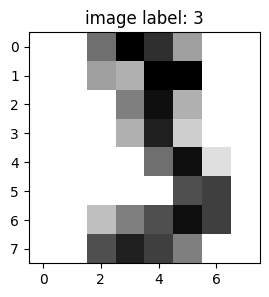

In [2]:
# visualize one image
sample_index = 45
plt.figure(figsize=(3, 3))
plt.imshow(digits.images[sample_index], cmap=plt.cm.gray_r,
           interpolation='nearest')
plt.title("image label: %d" % digits.target[sample_index]);

### Preprocessing

Of course, we need to split our data into training and testing sets before we use it, just the same as in Lab 1:

In [3]:
from sklearn.model_selection import train_test_split

data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

# Numpy Implementation

## a) Logistic Regression

In this section we will implement a logistic regression model trainable with SGD using numpy. Here are the objectives:

- Implement the softmax function $\sigma(\mathbf{x})_i = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}$;
- Implement the negative log likelihood function $NLL(Y_{true}, Y_{pred}) = - \sum_{i=1}^{n}{y_{true, i} \cdot \log(y_{pred, i})}$;
- Train a logistic regression model on the MNIST dataset;
- Evaluate the model on the training and testing sets.

Before we get there, let's write a function that one-hot encodes the class labels:

In [4]:
# This one hot categorization is turning the numerical value into an one hot embedding
## where everything is zero, and the one dimension your data belongs to is turning into one, representing this class.
def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

In [5]:
# create one one-hot embedding
one_hot(n_classes=10, y=3)

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [6]:
# create four one-hot embedding
one_hot(n_classes=10, y=[0, 4, 9, 1])

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

### The softmax function

Now we will implement the softmax function. Recall that the softmax function is defined as follows:

$$
softmax(\mathbf{x}) = \frac{1}{\sum_{i=1}^{n}{e^{x_i}}}
\cdot
\begin{bmatrix}
  e^{x_1}\\\\
  e^{x_2}\\\\
  \vdots\\\\
  e^{x_n}
\end{bmatrix}
$$

This is implemented for you using numpy - we want to be able to apply the softmax function to a batch of samples at once, so we will use numpy's vectorized operations to do so.

Our method also handles _stability issues_ that can occur when the values in `X` are very large. We will subtract the maximum value from each row of `X` to avoid overflow in the exponentiation. This isn't part of the softmax function itself, but it's a useful trick to know about.

In [7]:
# define the softmax function based on the mathematical formula
def softmax(X):
    # additional component if you work with big numbers
    ## if X itself is a very big number, the exponential of X can be huge. So we want to make sure we are shrinking the range of x to certain levels without changing the real value.
    #### without changing the order or the numerical relationship among all the values.
    X_max = np.max(X, axis=-1, keepdims=True)

    # use x - x_max, basically everybody goes down one step based on the x_max so every number now is fairly small compared with the original ones.
    ## get the exponential of everybody separately - element wise exponential of the x - x_max
    exp = np.exp(X - X_max) # Subtract the max to avoid overflow in the exponentiation

    # return the softmax(x) value
    return exp / np.sum(exp, axis=-1, keepdims=True)


Let's make sure that this works one vector at a time (and check that the components sum to one):

In [8]:
print(softmax([10, 2, -3]))

[9.99662391e-01 3.35349373e-04 2.25956630e-06]


When we are using our model to make predictions, we will want to be able to make predictions for multiple samples at once.
Let's make sure that our implementation of softmax works for a batch of samples:

In [9]:
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


Probabilities should sum to 1:

In [10]:
print(np.sum(softmax([10, 2, -3])))

1.0


In [11]:
print("softmax of 2 vectors:")
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

softmax of 2 vectors:
[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


The sum of probabilities for each input vector of logits should some to 1:

In [12]:
print(np.sum(softmax(X), axis=1))

[1. 1.]


Now we will implement a function that, given the true one-hot encoded class `Y_true` and some predicted probabilities `Y_pred`, returns the negative log likelihood.

Recall that the negative log likelihood is defined as follows:

$$
NLL(Y_{true}, Y_{pred}) = - \sum_{i=1}^{n}{y_{true, i} \cdot \log(y_{pred, i})}
$$

For example, if we have $y_{true} = [1, 0, 0]$ and $y_{pred} = [0.99, 0.01, 0]$, then the negative log likelihood is $- \log(0.99) \approx 0.01$.

In [13]:
# define negative log likelihood function, aka loss function or objective function or cross entropy
## to evaluate how well we're doing for using our model and how far we are with the ground truth we are trying to get to;
#### and used for evaluating the classification performance..
def nll(Y_true, Y_pred):
    Y_true = np.asarray(Y_true)
    Y_pred = np.asarray(Y_pred)

    # Ensure Y_pred doesn't have zero probabilities to avoid log(0)
    Y_pred = np.clip(Y_pred, 1e-15, 1 - 1e-15)

    # Calculate negative log likelihood
    loss = -np.sum(Y_true * np.log(Y_pred))
    return loss

# Make sure that it works for a simple sample at a time
print(nll([1, 0, 0], [.99, 0.01, 0]))

0.01005033585350145


We should see a very high value for this negative log likelihood, since the model is very confident that the third class is the correct one, but the true class is the first one:

In [14]:
print(nll([1, 0, 0], [0.01, 0.01, .98]))

4.605170185988091


Make sure that your implementation can compute the average negative log likelihood of a group of predictions: `Y_pred` and `Y_true` can therefore be past as 2D arrays:

In [15]:
# Check that the average NLL of the following 3 almost perfect
# predictions is close to 0
Y_true = np.array([[0, 1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])

Y_pred = np.array([[0,   1,    0],
                   [.99, 0.01, 0],
                   [0,   0,    1]])

print(nll(Y_true, Y_pred))

0.010050335853503449


Now that we have our softmax and negative log likelihood functions, we can implement a logistic regression model.
In this section, we have built the model for you, but you will need to complete a few key parts.

In [16]:
class LogisticRegression:

    def __init__(self, input_size, output_size):
        # Initialize the weights and biases with random numbers
        self.W = np.random.uniform(size=(input_size, output_size),
                                   high=0.1, low=-0.1)
        self.b = np.random.uniform(size=output_size,
                                   high=0.1, low=-0.1)

        # Store the input size and output size
        self.output_size = output_size
        self.input_size = input_size

    def forward(self, X):
        # Compute the linear combination of the input and weights
        Z = np.dot(X, self.W) + self.b

        # Return the softmax of the linear combination
        return softmax(Z)

    def predict(self, X):
        # Return the most probable class for each sample in X
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def loss(self, X, y):
        # Compute the negative log likelihood over the data provided

        ## turn numberic target into one_hot notation (the ground truth)
        y_true = one_hot(self.output_size, y)

        ## call this forward function to get the predictions of the input X
        y_pred = self.forward(X)

        # Return the loss function
        ## compare these two - ground truth and prediction - by calling the NLL function you implemented yourself
        return nll(y_true, y_pred)

    def grad_loss(self, X, y_true, y_pred):
        # Compute the gradient of the loss with respect to W and b for a single sample (X, y_true)
        # y_pred is the output of the forward pass

        # Gradient with respect to weights
        grad_W = np.dot(X.T, (y_pred - y_true))

        # Gradient with respect to biases
        grad_b = np.sum(y_pred - y_true, axis=0)

        # return the gradient of weights and biases
        return grad_W, grad_b

In [17]:
# Build a model and test its forward inference
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))
# initialize the logistic regression model randomly - just guessing
lr = LogisticRegression(n_features, n_classes)

We can evaluate the model on an example, visualizing the prediction probabilities:

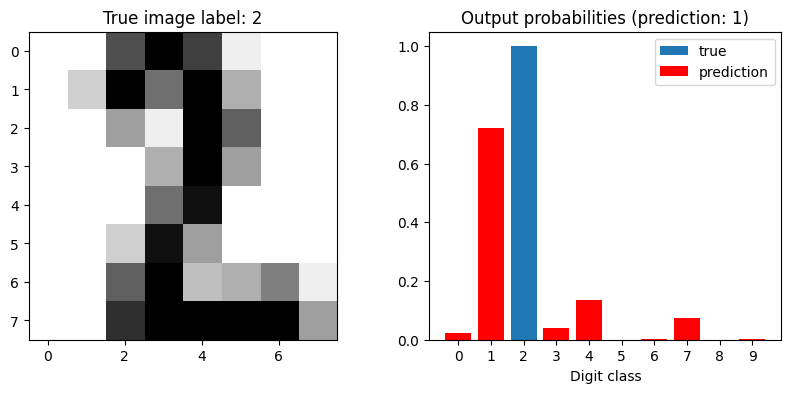

In [18]:
def plot_prediction(model, sample_idx=0, classes=range(10)):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    ax0.imshow(X_test[sample_idx:sample_idx+1].reshape(8, 8),
               cmap=plt.cm.gray_r, interpolation='nearest')
    ax0.set_title("True image label: %d" % y_test[sample_idx]);


    ax1.bar(classes, one_hot(len(classes), y_test[sample_idx]), label='true')
    ax1.bar(classes, model.forward(X_test[sample_idx]), label='prediction', color="red")
    ax1.set_xticks(classes)
    prediction = model.predict(X_test[sample_idx])
    ax1.set_title('Output probabilities (prediction: %d)'
                  % prediction)
    ax1.set_xlabel('Digit class')
    ax1.legend()

plot_prediction(lr, sample_idx=0)

Now it's time to start training! We will train for a single epoch, and then evaluate the model on the training and testing sets. Read through the following and make sure that you understand what we are doing here.

In [19]:
# initialize the logistic regression
lr = LogisticRegression(input_size=X_train.shape[1], output_size=10)

# set the learning rate to be 0.01 (default value re: sgd)
learning_rate = 0.01

# For all the elements inside the extreme model, we're going to get just one single example from it.
for i in range(len(X_train)):
    # Get the current sample and corresponding label
    ## this is where the scholastic gradient descent plays in.
    ### So we are, again, playing with a simple case where the batch size we're setting it to one.
    x = X_train[i:i+1]  # Reshape to keep the batch dimension
    y = y_train[i:i+1]  # Reshape to keep the batch dimension

    # Compute the forward pass and the gradient of the loss with respect to W and b
    ## For this small batch we're going to forward the input to our logistic regression to get the predicted y.
    y_pred = lr.forward(x)
    ## calculate the the grading loss of our model with regard of the weights and biases
    grad_W, grad_b = lr.grad_loss(x, one_hot(lr.output_size, y), y_pred)

    # Update the weights and biases
    ## update the weight and bias one step at the opposite step of this value (learning_rate * grad_W (or grad_b)).
    lr.W -= learning_rate * grad_W
    lr.b -= learning_rate * grad_b

    # above give me one iteration of update on one example of our data set.

    # Print the average negative log likelihood every 100 steps
    ## in order for us to understand how well the model is performing, whenever we hit 100 examples,
    ### we're going to print the loss of the data set and then see how well it's performing.
    if i % 100 == 0:
        avg_nll = lr.loss(X_train[max(0, i-100):i], y_train[max(0, i-100):i])
        print("Average NLL over the last 100 samples at step %d: %0.f" % (i, avg_nll))


Average NLL over the last 100 samples at step 0: -0
Average NLL over the last 100 samples at step 100: 442
Average NLL over the last 100 samples at step 200: 202
Average NLL over the last 100 samples at step 300: 451
Average NLL over the last 100 samples at step 400: 121
Average NLL over the last 100 samples at step 500: 185
Average NLL over the last 100 samples at step 600: 124
Average NLL over the last 100 samples at step 700: 60
Average NLL over the last 100 samples at step 800: 59
Average NLL over the last 100 samples at step 900: 186
Average NLL over the last 100 samples at step 1000: 155
Average NLL over the last 100 samples at step 1100: 63
Average NLL over the last 100 samples at step 1200: 95
Average NLL over the last 100 samples at step 1300: 153
Average NLL over the last 100 samples at step 1400: 55
Average NLL over the last 100 samples at step 1500: 33


Evaluate the trained model on the first example:

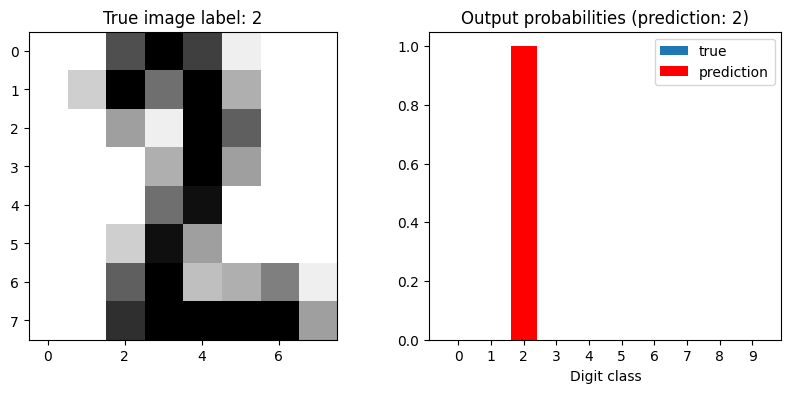

In [20]:
# plot the result of the current learning
plot_prediction(lr, sample_idx=0)

# there is no blue values as because they're completely overlap. So our prediction is exactly like what's happening in the ground truth.
## So we're doing a pretty good job in training the model.

## b) Feedforward Multilayer

The objective of this section is to implement the backpropagation algorithm (SGD with the chain rule) on a single layer neural network using the sigmoid activation function.

Now it's your turn to

- Implement the `sigmoid` and its element-wise derivative `dsigmoid` functions:

$$
sigmoid(x) = \frac{1}{1 + e^{-x}}
$$

$$
dsigmoid(x) = sigmoid(x) \cdot (1 - sigmoid(x))
$$

Remember that you can use your `sigmoid` function inside your `dsigmoid` function.

Just like with our softmax function, we also want to make sure that we don't run into stability issues with our sigmoid function. We will use `np.clip` to ensure that the input to the sigmoid function is not too large or too small.

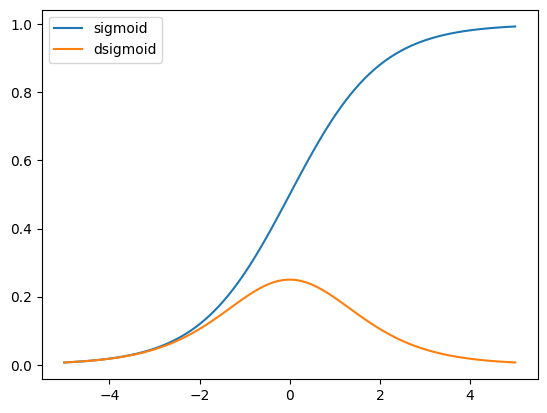

In [21]:
# define sigmoid function
def sigmoid(X):
    # Clip X into a range to prevent overflow or underflow
    X = np.clip(X, -500, 500) # This ensures that np.exp(X) doesn't overflow
    return 1 / (1 + np.exp(-X))

# define dsigomoid function - the derivative of sigmoid function
def dsigmoid(X):
    return sigmoid(X) * (1 - sigmoid(X))


x = np.linspace(-5, 5, 100)
plt.plot(x, sigmoid(x), label='sigmoid')
plt.plot(x, dsigmoid(x), label='dsigmoid')
plt.legend(loc='best');

Now it's your turn to complete the neural network code, so that we can train it on the MNIST dataset.

Some parts have been completed for you already. Often, you'll be able to refer back to the code from the previous section to help you complete the code in this section.

In [24]:
# define a neural network with crucial functions
class NeuralNet():
    """MLP with 1 hidden layer with a sigmoid activation"""

    def __init__(self, input_size, hidden_size, output_size):
        # Initializes the weights with random numbers
        self.W_h = np.random.uniform(size=(input_size, hidden_size),
                                     high=0.1, low=-0.1)
        self.b_h = np.random.uniform(size=hidden_size,
                                     high=0.1, low=-0.1)
        self.W_o = np.random.uniform(size=(hidden_size, output_size),
                                     high=0.1, low=-0.1)
        self.b_o = np.random.uniform(size=output_size,
                                     high=0.1, low=-0.1)

        # Store the input size, hidden size and output size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size


    # implement in the details of those two functions in teh forward() function:
    ## the forward hidden layer, we are going to do similar to
    ### what we have done inside the logic regression.
    #### We're doing a linear path of the input - dot product between x and the weight h plus the bias term.
    def forward_hidden(self, X):
        # Compute the linear combination of the input and weights
        self.Z_h = np.dot(X, self.W_h) + self.b_h

        # Apply the sigmoid activation function
        ## add a sigmoid nonlinear operators on top of the output of this linear operations - self.Z_h.
        return sigmoid(self.Z_h)

    ## For the forward upward path, we're going to do similar things with a different set of weights instead of WH, BH,
    ### we're using WO, BO representing the weights and bias for output layer.
    def forward_output(self, H):
        # Compute the linear combination of the hidden layer activation and weights
        self.Z_o = np.dot(H, self.W_o) + self.b_o

        # Apply the sigmoid activation function
        ## in order for us to do a softmax,
        ### do a classification we're using softmax
        #### so we can turn this into a one to ten to the probability distribution
        ##### that we want to use for the future comparison.
        ## use softmax because the output would be in the probability range that's more intuitively understandable.
        return softmax(self.Z_o)


    # define the forward function - defines how x is being turned into y
    # let's look at how the forward is being implemented. it requires two steps
    def forward(self, X):

        # Compute the forward activations of the hidden and output layers
        ## - calling the two funtions

        ## One is we're turning the input into the hidden layer output,
        H = self.forward_hidden(X)

        ## and then we're using the hidden layer output
        ### and give it to the upper layer to get the final output.
        Y = self.forward_output(H)

        return Y


    # define the loss function where we're calculating - the negative log likelihood -
    ## how far we are your result is towards the target comparing two sets of results.
    ### One is the prediction we're getting by calling the function forward and the ground truths were given.
    def loss(self, X, y):
        # The original Y is a numerical value, so we need to leverage in the one hot function
        ## we implemented to turn this into the same shape for these two comparisons
        ### So that's the loss function that we need.
        y_pred = one_hot(self.output_size, y)
        y_true = self.forward(X)

        return nll(y_pred, y_true)


    # define the gradient loss function
    ## So we know for each of the parameters you're using inside your function,
    ### how you're going to update it.
    #### how you're going to calculate the derivatives and using this for updating the parameters.
    ##### Basically, we're using the chain rule to calculating what should be the loss
    ###### with regard of each of the parameters and we're using this to define what is the gradient of each
    ####### and then using this to get the final result.
    def grad_loss(self, X, y_true):
        y_true = one_hot(self.output_size, y_true)
        y_pred = self.forward(X)

        # Compute the error at the output layer
        error_o = y_pred - y_true

        # Compute the gradient of the loss with respect to W_o and b_o
        grad_W_o = np.dot(self.Z_h.T, error_o)
        grad_b_o = np.sum(error_o, axis=0)

        # Compute the error at the hidden layer
        error_h = np.dot(error_o, self.W_o.T) * dsigmoid(self.Z_h)

        # Compute the gradient of the loss with respect to W_h and b_h
        grad_W_h = np.dot(X.T, error_h)
        grad_b_h = np.sum(error_h, axis=0)

        return {"W_h": grad_W_h, "b_h": grad_b_h, "W_o": grad_W_o, "b_o": grad_b_o}


    # during the training steps
    ## We're going to take in one batch of the input so this train is doing the SGD part,
    ### taking one batch of the input, using the learning rate you set,
    def train(self, x, y, learning_rate):

        ## and then do one round of the getting the output of the model
        # Ensure x is 2D
        x = x[np.newaxis, :]
        # Compute the gradient for the sample and update the weights
        grads = self.grad_loss(x, y)

        ## and updating all the parameters based on the learning rates.
        self.W_h -= learning_rate * grads["W_h"]
        self.b_h -= learning_rate * grads["b_h"]
        self.W_o -= learning_rate * grads["W_o"]
        self.b_o -= learning_rate * grads["b_o"]


    # the prediction function is just a simple function for us
    ## to get the axis that contains the largest probability after a forward pass.
    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)


    # accuracy is a function that we use to calculating the performance of your entire data set.
    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

Once the code is written, we can test our model on a single sample:

In [25]:
n_hidden = 10
# randomly initialize the neural network - not trained yet
model = NeuralNet(n_features, n_hidden, n_classes)

In [26]:
model.loss(X_train, y_train)

3536.5218473413943

In [27]:
model.accuracy(X_train, y_train)

0.08447937131630648

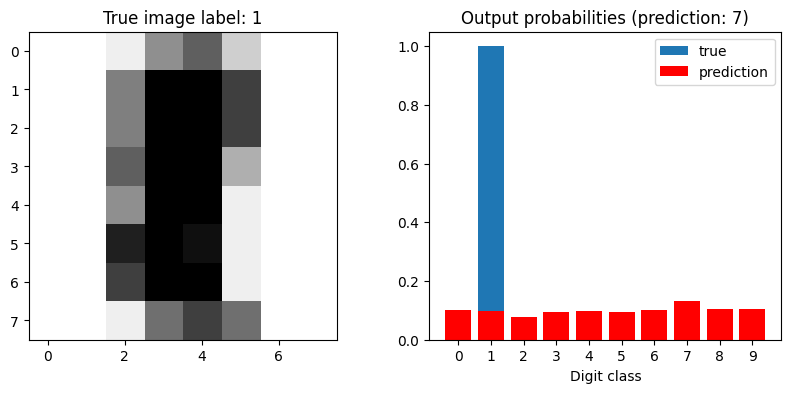

In [28]:
plot_prediction(model, sample_idx=5)

And now it's time to train!

In [29]:
# train the neural network
losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))


# initiate the training on top of the data with 15 different epochs.
for epoch in range(15):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        # then for each of the time, we're going to do a small update of the model
        ## based on just one example from the entire data set.
        model.train(x, y, 0.001)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))


    # at the end of each epoch, once we finish going through all the examples,
    ## once we're printing model performance and see if things are getting better
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

Random init: train loss: 3536.52185, train acc: 0.084, test acc: 0.089
Epoch #1, train loss: 2871.13572, train acc: 0.456, test acc: 0.474
Epoch #2, train loss: 2085.47422, train acc: 0.724, test acc: 0.722
Epoch #3, train loss: 1483.57424, train acc: 0.853, test acc: 0.841
Epoch #4, train loss: 1077.44914, train acc: 0.898, test acc: 0.874
Epoch #5, train loss: 818.59430, train acc: 0.925, test acc: 0.907
Epoch #6, train loss: 653.26426, train acc: 0.936, test acc: 0.926
Epoch #7, train loss: 543.07456, train acc: 0.949, test acc: 0.930
Epoch #8, train loss: 465.98344, train acc: 0.955, test acc: 0.944
Epoch #9, train loss: 411.93086, train acc: 0.959, test acc: 0.937
Epoch #10, train loss: 370.91635, train acc: 0.963, test acc: 0.937
Epoch #11, train loss: 338.18622, train acc: 0.965, test acc: 0.941
Epoch #12, train loss: 311.87889, train acc: 0.969, test acc: 0.941
Epoch #13, train loss: 290.48746, train acc: 0.969, test acc: 0.941
Epoch #14, train loss: 272.67000, train acc: 0.972

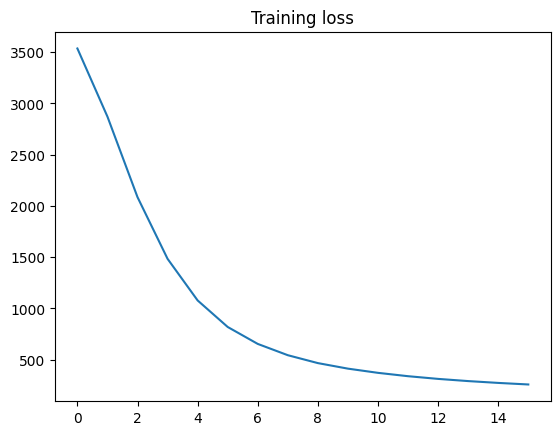

In [30]:
plt.plot(losses)
plt.title("Training loss");

# So if you're printing the training loss, you should be able to see that after each epochs, your training loss is going pretty small
## Going down and this seems like there's still a little bit of room to go down, but very little left.
### So things are doing pretty well in that sense.

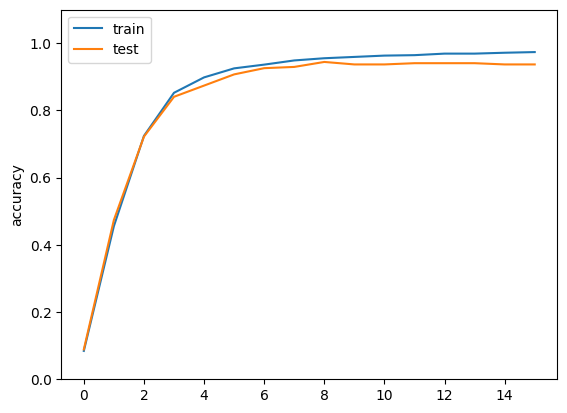

In [31]:
plt.plot(accuracies, label='train')
plt.plot(accuracies_test, label='test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy")
plt.legend(loc='best');

# printing the result of the training set and the test set.
## So what we're trying to do here is in some ways trying to understand if our model is overfitting or not.
### So ideally, you should be able to see that your model is still performing well on test set.
#### But if you see a big drop of the test set performance and the training side is still going up, then probably means that your model is overfitting.


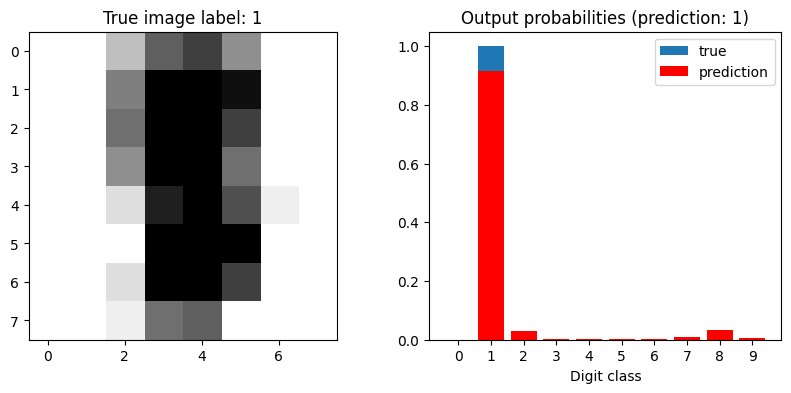

In [32]:
plot_prediction(model, sample_idx=4)

## c) Exercises

### Look at worst prediction errors

- Use numpy to find test samples for which the model made the worst predictions,
- Use the `plot_prediction` to look at the model predictions on those,
- Would you have done any better?

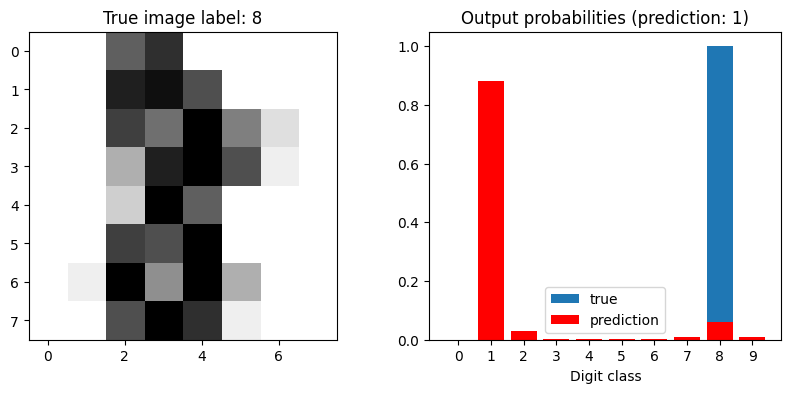

In [34]:
# how to find the worst cases
## and then looking at what's the original input and why the model is making that wrong case - making that the wrong prediction?

# Get the model's predictions of y on the test set
y_pred = model.predict(X_test)

# Find the indices of the samples where the model's prediction was wrong
## get all the cases that the prediction doesn't equal to the ground truth.
wrong_indices = np.where(y_pred != y_test)[0]

# For each wrong prediction, get the model's confidence of that run class in its prediction
## If the model is extremely confident about the wrong prediction means that
### they're being very far away from the correct answer and that should be something that we avoid doing.
## for each of the round prediction, we're getting the model confidence of the prediction.
### np.max() is the class it predicted to be.
confidences = np.max(model.forward(X_test[wrong_indices]), axis=1)

# Find the index of the sample where the model was most confident but wrong
## find the cases where they're most confident about this one class using np.argmax()
### and they're getting that the index of that example and then plot this example
worst_index = wrong_indices[np.argmax(confidences)]

# Use the 'plot_prediction' function to look at the model's prediction on this sample
plot_prediction(model, sample_idx=worst_index)


### Hyper parameters settings

- Experiment with different hyperparameters:
  - learning rate,
  - size of hidden layer,
  - implement the support for a second hidden layer.
  - What is the best test accuracy you can get?

hyperparameters are not the parameters inside the model itself, like not the zeta that we've been talking about the whole time.  
It is the parameters that were used for defining our models or used for defining our training and updating strategies, like some of the common ones is like the learning rate we're using, the batch size we're using.  
How many hidden layers we're going to concatenating for generating the for construct the entire network, how wide each of the layers that you want your hidden layer to be - whether it's 64 or 32.?

In [36]:
# Define the hyperparameters to try
learning_rates = [0.001, 0.01, 0.1]
hidden_sizes = [10, 50, 100]

# Initialize the best accuracy to 0
best_accuracy = 0

# For each combination of hyperparameters
for learning_rate in learning_rates:
    for hidden_size in hidden_sizes:
        # Create and train a new model
        model = NeuralNet(n_features, hidden_size, n_classes)
        for epoch in range(15):
            for i, (x,y) in enumerate (zip(X_train, y_train)):
                model.train(x, y, learning_rate)

        # Calculate the model's accuracy on the test set
        accuracy = model.accuracy(X_test, y_test)

        # If this model is better than the previous best model, update the best model and best accuracy
        if accuracy > best_accuracy:
            best_model = model
            best_accuracy = accuracy


# Print the best accuracy
print("Best test accuracy:", best_accuracy)


# Output:
# Best test accuracy: 0.9703703703703703

Best test accuracy: 0.9703703703703703
